In [1]:
import os
import json
import h5py
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.optim import Adam 
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from copy import deepcopy
import datetime
import tqdm

import imageio

import sys 
sys.path.append("/home/ns1254/nn_project/gym-pusht/gym_pusht/envs/")
from pusht import *

In [2]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
dataset_path = "/home/ns1254/data_pusht/pusht_hf_206.hdf5" 
f = h5py.File(dataset_path, "r")
demos = list(f["data"].keys())
num_demos = len(demos)
print(f'Number of demos: {num_demos}')

Number of demos: 206


In [4]:
select_keys=['images'] 

In [5]:
actions_list=[]
obs_list=[]
for i,demo_id in enumerate(demos): 
    traj=f['data'][demo_id]

    # actions=traj['actions']
    actions = traj['dactions']
    select_obs=traj['obs']['images'] 
    select_obs=np.array(select_obs).transpose(0,3,1,2)
    actions_list.append(actions)
    obs_list.append(select_obs)
    
actions=np.concatenate(actions_list, axis=0)
states=np.concatenate(obs_list, axis=0)

actions.shape, states.shape

((25650, 2), (25650, 3, 96, 96))

In [6]:
data_loader_train = DataLoader( list(zip(states, actions)), batch_size=64, shuffle=True) 

batch=next(iter(data_loader_train))
states,actions = batch
states.shape,actions.shape

(torch.Size([64, 3, 96, 96]), torch.Size([64, 2]))

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(8 * 48 * 48, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(-1, 8 * 48 * 48)
         
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
learning_rate = 1e-4 

model = SimpleCNN().to(device)
criterion = nn.MSELoss() 
optimizer = Adam(model.parameters(), lr = learning_rate)

In [ ]:
n_epoch = 600
losses=[] 
for itr in tqdm.tqdm(range(1, n_epoch+1)):
    model.train()
    train_loss = 0
    b=0
    for batch_states, batch_actions in data_loader_train: 
        batch_states = batch_states.to(device)
        batch_actions = batch_actions.to(device)
        y_pred = model(batch_states.float())
        loss   = criterion(y_pred, batch_actions.float()) 
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        b += 1   
    
    train_loss=train_loss/b
    losses.append(train_loss)
    
    if itr % (n_epoch//60) == 0:
        print(f'Epoch {itr} Train.Loss: {train_loss:.4f}')

  0%|          | 0/600 [00:00<?, ?it/s]

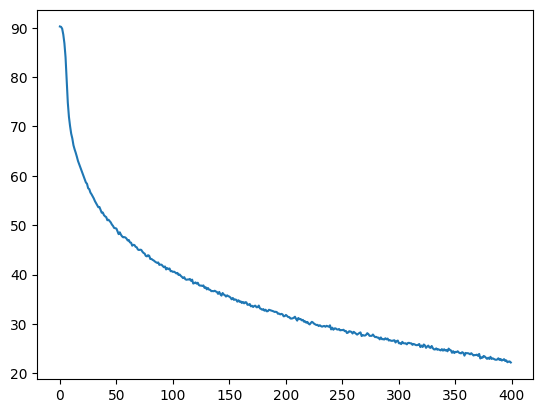

In [12]:
plt.plot(losses)

In [13]:
demo_id = demos[0]
traj=f['data'][demo_id]
actions=traj['dactions']
# states=traj['obs']['states']
select_obs=traj['obs']['images'] 
states=np.array(select_obs).transpose(0,3,1,2)
actions.shape, states.shape

((161, 2), (161, 3, 96, 96))

In [16]:
model.eval()
y_pred = model(batch_states.float())

y_pred.shape, batch_states.shape

(torch.Size([50, 2]), torch.Size([50, 3, 96, 96]))

In [22]:
model.eval()
states_tensor = torch.tensor(states).float().to(device)
actions_pred = model(states_tensor).detach().cpu().numpy()

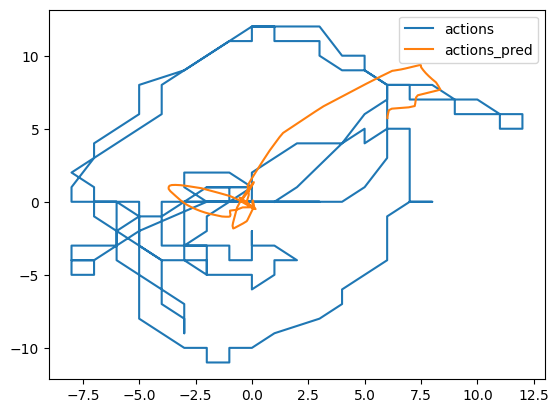

In [16]:
plt.plot(actions[:,0], actions[:,1], label='actions')
plt.plot(actions_pred[:,0], actions_pred[:,1], label='actions_pred')
plt.legend()
plt.show()

In [21]:
env=PushTEnv()

state,info=env.reset()
ax,ay=info['pos_agent']
ax, ay

(55.0, 116.0)

In [22]:
env=PushTEnv()

state,info=env.reset()
ax,ay=info['pos_agent']
 

bc.eval()
max_steps=1000
rewards=[]
rgbs=[]
for i in range(max_steps):
    state_tensor = torch.tensor(state).float().to(device)
    action_pred = bc(state_tensor).detach().cpu().numpy()
    action_pred = action_pred
    action=[ax + action_pred[0] , ay + action_pred[1]]
    state,reward,done,trunc,info=env.step(action_pred)

    ax,ay=info['pos_agent']
    rgb=env.render()
    rgbs.append(rgb)
    rewards.append(reward)
    if done:
        break

print(f"Total reward: {sum(rewards)}")

Total reward: 0.0


In [23]:
imageio.mimsave('bc_pusht.mp4', rgbs, fps=30)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (680, 680) to (688, 688) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


[swscaler @ 0x5709e80] Warning: data is not aligned! This can lead to a speed loss
